In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from scipy import interpolate
from scipy import integrate
from scipy.optimize import fsolve
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
import healpy as hp

import os
from os import listdir
from os.path import isfile, join

from multiprocessing import Pool
import time
from numba import njit

import sys
from tqdm import tqdm

In [3]:
href=67 #69
Om0GLOB=0.319
Xi0Glob =1.
clight = 2.99792458* 10**5#km/s
cosmoflag = FlatLambdaCDM(H0=href, Om0=Om0GLOB)
@njit
def E_z(z, H0, Om=Om0GLOB):
    return np.sqrt(Om*(1+z)**3+(1-Om))

def r_z(z, H0, Om=Om0GLOB):
    c = clight
    integrand = lambda x : 1/E_z(x, H0, Om)
    integral, error = integrate.quad(integrand, 0, z)
    return integral*c/H0

def Dl_z(z, H0, Om=Om0GLOB):
    return r_z(z, H0, Om)*(1+z)
def z_dc(dc,h,om=Om0GLOB):
    func = lambda z :r_z(z, h, Om0GLOB) - dc
    zres = fsolve(func, 0.02)[0] 
    return zres
@njit
def phi2RA(phi):
    ret=np.rad2deg(phi)
    return ret
@njit
def theta2DEC(theta):
    ret=np.rad2deg(0.5*np.pi-theta)
    return ret
@njit
def RA2phi(RA):
    ret=np.deg2rad(RA)
    return ret
@njit
def DEC2theta(DEC):
    ret=0.5 * np.pi - np.deg2rad(DEC)
    return ret

In [4]:
#Catalogue path
cat_data_path='/home/rciancarella/DarkSirensStat/data/GLADE/'
os.chdir(cat_data_path)
#all_event=os.listdir()
#print(all_event)
save_cat_path='/home/rciancarella/DarkSirensStat/MyDSStat/'

# Loading The Flagship 

In [ ]:
flag = pd.read_csv('GLADE_flagship.txt', sep=" ", header=None)
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
flag.columns=colnames

In [ ]:
z_flag_min=flag['z'].min()
z_flag_max=flag['z'].max()
Nobj=flag.shape[0]
dl_flag_min=flag['dl'].min()
dl_flag_max=flag['dl'].max()
RA_flag_min=flag['right_ascension_degrees'].min()
RA_flag_max=flag['right_ascension_degrees'].max()
DEC_flag_min=flag['declination_degrees'].min()
DEC_flag_max=flag['declination_degrees'].max()
phi_flag_min=RA2phi(RA_flag_min)
phi_flag_max=RA2phi(RA_flag_max)
theta_flag_min=DEC2theta(DEC_flag_max)
theta_flag_max=DEC2theta(DEC_flag_min)
print('MotherCat Info:')
print('ref Cosmology={}'.format(cosmoflag))
print('Num of objects={}'.format(Nobj))
print('phi min={}, phi max={}, theta min={}, theta max={}'.format(phi_flag_min,phi_flag_max,theta_flag_min,theta_flag_max))
print('z min={},z max={}'.format(z_flag_min,z_flag_max))
print('dl min={}, dl max={}'.format(dl_flag_min, dl_flag_max))

In [ ]:
delta_phi=phi_flag_max-phi_flag_min
theta_part=np.cos(theta_flag_min)-np.cos(theta_flag_max)
integrand=lambda x:clight*(cosmoflag.comoving_distance(x).value)**2/(cosmoflag.H(x).value)
z_part=integrate.quad(integrand,z_flag_min,z_flag_max)[0]

Volume=delta_phi*theta_part*z_part#integrand
print('Cat Volume {} Gpc^3'.format(Volume/1000**3))
Density=Nobj/Volume
print('Cat Density {} #/Mpc^3'.format(Density))

# Evaluating N(z)
chiedere se conviene usare direttamente la flag o la N(z) che mi aveva dato Melita

In [ ]:
z_flag=np.asarray(flag['z'])
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))


nbins=30
(n, bins, patches)=ax.hist(z_flag,bins=nbins,range=(z_flag_min,z_flag_max))
half_step=(bins[1]-bins[0])/2
mybins=bins[:-1]+half_step
myN=interpolate.interp1d(mybins,n,kind='cubic',fill_value='extrapolate')
ax.scatter(mybins,n,color=colors[3])


ax.plot(mybins,myN(mybins),color=colors[3])
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=20)

# Make the True Universe
First we need to generate an uniform catalogue in comoving volume. This imply a cosmology. We need a fixed and constant comoving density. The number of object in the most pupulated bin of the data must be the same as the uniform cat

In [ ]:
nmax=n.max()
idx=np.where(n==nmax)[0]
zbin_min=bins[idx]
z_bin_max=bins[idx+1]
integrand=lambda x:clight*(cosmoflag.comoving_distance(x).value)**2/(cosmoflag.H(x).value)
z_part=integrate.quad(integrand,zbin_min,z_bin_max)[0]
bin_vol=theta_part*delta_phi*z_part
unif_density=nmax/bin_vol
uniform_numb=int(unif_density*Volume)+1
#-----------------------------------------------------------------------------
dcom_min=cosmoflag.comoving_distance(z_flag_min).value
dcom_max=cosmoflag.comoving_distance(z_flag_max).value
dl_min=cosmoflag.luminosity_distance(z_flag_min).value
dl_max=cosmoflag.luminosity_distance(z_flag_max).value
#-----------------------------------------------------------------------------
print('Catalogue:\nz_min={}, z_max={},\nphi_min={}, phi_max={}, theta_min={}, theta_max={}'
      .format(z_flag_min,z_flag_max,phi_flag_min,phi_flag_max,theta_flag_min,theta_flag_max))


In [ ]:
cat_name='Uniform_from_flag_big.txt'


#------------------points generator------------------
u = np.random.uniform(0,1,size=uniform_numb) # uniform random vector of size nsamp
dc_gals_all     = np.cbrt((u*dcom_min**3)+((1-u)*dcom_max**3))
phi_gals   = np.random.uniform(phi_flag_min,phi_flag_max,uniform_numb)
theta_gals = np.arccos( np.random.uniform(np.cos(theta_flag_max),np.cos(theta_flag_min),uniform_numb) )
dc_gals=dc_gals_all[dc_gals_all>=dcom_min]
new_phi_gals=np.random.choice(phi_gals,len(dc_gals))
new_theta_gals=np.random.choice(theta_gals,len(dc_gals))


In [ ]:
'''# need to use pool here
    for i in tqdm(range(len(dc_gals))):
        z=z_dc(dc_gals[i],href,Om0GLOB)
        z_gals[i]=z
        dl_gals[i]=Dl_z(z,href,Om0GLOB)
    new_phi_gals=np.random.choice(phi_gals,len(dc_gals))
    new_theta_gals=np.random.choice(theta_gals,len(dc_gals))

    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
    MyCat = pd.DataFrame(columns=colnames)
    MyCat['Ngal']=num
    MyCat['Comoving Distance']=dc_gals
    MyCat['Luminosity Distance']=dl_gals
    MyCat['z']=z_gals
    MyCat['phi']=new_phi_gals
    MyCat['theta']=new_theta_gals
    print('Saving '+cat_name)
    MyCat.to_csv(cat_name, header=None, index=None, sep=' ')'''

In [ ]:
def uniform_volume(iterations):
#for i in tqdm(range(flagship.shape[0])):
#for i in range(iterations):
    i=iterations
    numevent=i
    phigal=new_phi_gals[i]
    thetagal=new_theta_gals[i]
    dc=dc_gals[i]
    #----------z----------------------
    zz=z_dc(dc,href,Om0GLOB)
    dl=Dl_z(zz,href,Om0GLOB)
    #----------row to append---------------------
    proxy_row={'Ngal':numevent,'Comoving Distance':dc,'Luminosity Distance':dl,
               'z':zz,'phi':phigal,'theta':thetagal
          }
    return proxy_row
def z_from_dcom(dc_val):
    '''
    Returns redshift for a given comoving distance dc (in Mpc)'''
    
    func = lambda z :cosmoflag.comoving_distance(z).value - dc_val
    z = fsolve(func, 0.5)
    return z[0]

In [ ]:
numevent=int(0)
proxy_row={'Ngal':numevent,'Comoving Distance':0,'Luminosity Distance':0,
               'z':0,'phi':0,'theta':0
          }

In [ ]:
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
uniform_scaled = pd.DataFrame(columns=colnames)
#glade_like.columns=colnames
uniform_scaled.head()

In [ ]:
from tqdm import tqdm
arr=np.arange(0,len(dc_gals),dtype=int)
data=[]
tmp=[]
start_time = time.time()
print('I am Doing my best, please wait...')
with Pool(14) as p, tqdm(total=len(arr)) as pbar:
    tmp=p.map(uniform_volume, arr)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
uniform_scaled=uniform_scaled.append(tmp, ignore_index=True)

In [ ]:
os.chdir(save_cat_path)
uniform_scaled.to_csv(cat_name, header=None, index=None, sep=' ')

# Plot The results

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

#nbins=30
(n_unif,bin_unif,patches_unif)=ax.hist(uniform_scaled['z'],bins=nbins,range=(z_flag_min,z_flag_max),color=colors[9])
(n_flag,bin_flag,patches_flag)=ax.hist(z_flag,bins=nbins,range=(z_flag_min,z_flag_max),color=colors[-1])

ax.scatter(mybins,n,color=colors[3])
#ax.plot(mybins,myN(mybins),color=colors[3])
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=20)

In [ ]:
mask=n_flag>n_unif
print(np.sum(mask))

# Statistical Weights $w$(z)

In [ ]:
flag_over_unif=n_flag/n_unif
w_hist=1/flag_over_unif
w=interpolate.interp1d(mybins,w_hist,kind='cubic',fill_value='extrapolate')

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))


nbins=30
ax.plot(mybins,w(mybins),color=colors[3])
#ax.plot(mybins,myN(mybins),color=colors[3])
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$w(z)$', fontsize=20)

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))


nbins=30
ax.plot(mybins,w(mybins)/np.max(w(mybins)),color=colors[-2])
ax.plot(mybins,myN(mybins)/np.max(myN(mybins)),color=colors[3])
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$w(z)$', fontsize=20)

In [ ]:
#np.savetxt('weights_bin.txt', mybins)
#np.savetxt('weights.txt', w(mybins))

# Save the flagship for postcalculator.py

In [ ]:
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
filtered_flag = pd.DataFrame(columns=colnames)
#glade_like.columns=colnames
#filtered_flag.head()

In [ ]:
flag.head(1)

In [ ]:
Ngal=np.arange(flag.shape[0])
dl_to_save=flag['dl'].values
z_to_save=flag['z'].values
dc_to_save=dl_to_save/(1+z_to_save)
phi_to_save=RA2phi(flag['right_ascension_degrees'].values)
theta_to_save=DEC2theta(flag['declination_degrees'].values)

In [ ]:
filtered_flag['Ngal']=Ngal
filtered_flag['Comoving Distance']=dc_to_save
filtered_flag['Luminosity Distance']=dl_to_save
filtered_flag['z']=z_to_save
filtered_flag['phi']=phi_to_save
filtered_flag['theta']=theta_to_save

In [ ]:
filtered_flag.head()
os.chdir(save_cat_path)
filtered_flag.to_csv('Flag.txt', header=None, index=None, sep=' ')

# Extraction from the uniform
Now, for each bin of the data, we thake that many host from the flagship, thus keeping the structure of the catalogue

In [ ]:
os.chdir(save_cat_path)

In [ ]:
unif = pd.read_csv('Uniform_from_flag_big.txt', sep=" ", header=None)
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
unif.columns=colnames

flag = pd.read_csv('Flag.txt', sep=" ", header=None)
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
flag.columns=colnames

In [ ]:
z_flag_min=np.min(flag['z'])
z_flag_max=np.max(flag['z'])


In [ ]:
dilution = pd.DataFrame(columns = colnames)
dilution=flag.sample(frac=0.5)

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

nbins=30

(n_unif,bin_unif,patches_unif)=ax.hist(unif['z'],bins=nbins,range=(z_flag_min,z_flag_max),color='springgreen')
(n_flag,bin_flag,patches_flag)=ax.hist(dilution['z'],bins=nbins,range=(z_flag_min,z_flag_max),color='teal')

#ax.scatter(mybins,n,color=colors[3])
#ax.plot(mybins,myN(mybins),color=colors[3])
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=20)

In [ ]:
mask=n_flag>n_unif
print(np.sum(mask))#if is 0 then ok

In [ ]:
factor=(n_flag[1]+1000)/n_unif[1]
puppet_unif=unif.sample(frac=factor)

In [ ]:
print(factor)

In [ ]:
half_step=(bin_unif[1]-bin_unif[0])/2
mybins=bin_unif[:-1]+half_step
n=n_unif-n_flag

In [ ]:
result = pd.DataFrame(columns = colnames)

In [ ]:
for i in range(len(mybins)):
    temp_bin=unif[unif['z']>=mybins[i]-half_step]
    temp_bin=temp_bin[temp_bin['z']<=mybins[i]+half_step]
    temp_bin=temp_bin.sample(round(n[i]))
    result=result.append(temp_bin, ignore_index=True)

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

#nbins=30
#(n_unif,bin_unif,patches_unif)=ax.hist(unif['z'],bins=nbins,range=(z_flag_min,z_flag_max),color=colors[9])
(n_puppet,bin_puppet,patches_diluted)=ax.hist(puppet_unif['z'],bins=nbins,range=(z_flag_min,z_flag_max),color=colors[5])
(n_flag,bin_flag,patches_flag)=ax.hist(dilution['z'],bins=nbins,range=(z_flag_min,z_flag_max),color='teal')
#ax.scatter(mybins,n_diluted+n_flag,color='purple',marker='x')
#ax.plot(mybins,myN(mybins),color=colors[3])
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=20)

In [ ]:
mask=n_flag>n_puppet
print(np.sum(mask))

In [ ]:
os.chdir(save_cat_path)
puppet_unif.to_csv('Uniform_for_half_flag.txt', header=None, index=None, sep=' ')

In [ ]:
os.chdir(save_cat_path)
dilution.to_csv('half_flag.txt', header=None, index=None, sep=' ')

In [ ]:
flag_over_unif=n_flag/n_puppet
print(np.max(flag_over_unif))
w_hist=1/flag_over_unif
w_normed=w_hist/np.sum(w_hist)
w=interpolate.interp1d(mybins,w_normed,kind='cubic',fill_value='extrapolate')

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))


ax.plot(mybins,w(mybins),color=colors[3])
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$w(z)$', fontsize=20)

In [ ]:
np.savetxt('half_flag_bin.txt', mybins)
np.savetxt('half_flag_weights.txt', w_normed)

# Extrac a uniform with Flag N(z)

In [ ]:
smallunif = pd.read_csv('Uniform_for_half_flag.txt', sep=" ", header=None)
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
smallunif.columns=colnames

In [ ]:
dilution = pd.read_csv('half_flag.txt', sep=" ", header=None)
dilution.columns=colnames

In [ ]:
smallunif.shape

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

nbins=30
(n_unif,bin_unif,patches_unif)=ax.hist(smallunif['z'],bins=nbins,range=(smallunif['z'].min(),smallunif['z'].max()),color=colors[9])
#(n_result,bin_result,patches_result)=ax.hist(result['z'],bins=nbins,range=(z_flag_min,z_flag_max),color=colors[5])
(n_flag,bin_flag,patches_flag)=ax.hist(dilution['z'],bins=nbins,range=(smallunif['z'].min(),smallunif['z'].max()),color='teal')
#ax.scatter(mybins,n_flag,color='purple',marker='x')
#ax.plot(mybins,myN(mybins),color=colors[3])
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=20)

In [ ]:
half_step=(bin_unif[1]-bin_unif[0])/2
mybins=bin_unif[:-1]+half_step
result = pd.DataFrame(columns = colnames)
for i in range(len(mybins)):
    temp_bin=smallunif[smallunif['z']>=mybins[i]-half_step]
    temp_bin=temp_bin[temp_bin['z']<=mybins[i]+half_step]
    temp_bin=temp_bin.sample(round(n_flag[i]))
    result=result.append(temp_bin, ignore_index=True)

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

nbins=30
(n_unif,bin_unif,patches_unif)=ax.hist(smallunif['z'],bins=nbins,range=(smallunif['z'].min(),smallunif['z'].max()),color=colors[9])
(n_result,bin_result,patches_result)=ax.hist(result['z'],bins=nbins,range=(smallunif['z'].min(),smallunif['z'].max()),color=colors[5])
#(n_flag,bin_flag,patches_flag)=ax.hist(dilution['z'],bins=nbins,range=(smallunif['z'].min(),smallunif['z'].max()),color='teal')

ax.scatter(mybins,n_flag,color='purple',marker='x')

ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=20)

In [ ]:
href=67 #69
Om0GLOB=0.319
Xi0Glob =1.
clight = 2.99792458* 10**5#km/s
cosmoflag = FlatLambdaCDM(H0=href, Om0=Om0GLOB)
@njit
def E_z(z, H0, Om=Om0GLOB):
    return np.sqrt(Om*(1+z)**3+(1-Om))

def r_z(z, H0, Om=Om0GLOB):
    c = clight
    integrand = lambda x : 1/E_z(x, H0, Om)
    integral, error = integrate.quad(integrand, 0, z)
    return integral*c/H0

def Dl_z(z, H0, Om=Om0GLOB):
    return r_z(z, H0, Om)*(1+z)
def z_dc(dc,h,om=Om0GLOB):
    func = lambda z :r_z(z, h, Om0GLOB) - dc
    zres = fsolve(func, 0.02)[0] 
    return zres
def h_ofzdc(z,dc,Om=Om0GLOB):
    func= lambda h: r_z(z, h, Om0GLOB)-dc
    hres=fsolve(func, 60)[0]
    return hres

In [ ]:
my_dl=smallunif['Luminosity Distance']
my_sca=smallunif['scattered DL']
sigma=0.1*my_dl
diff=(my_dl-my_sca)/sigma

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

nbins=30
(n_scat,bin_scat,patches_scat)=ax.hist(diff,bins=nbins,range=(-3,3),color=colors[9])

In [ ]:
os.chdir(save_cat_path)
#result.to_csv('Uniform_Nz_half_flag.txt', header=None, index=None, sep=' ')

# Arbitrary N(z)

In [26]:
from numpy.random import random
#-----------rejection-stuff------------
def sample(g,xmin,xmax):
    x = np.linspace(xmin,xmax,1000000)
    y = g(x)                        # probability density function, pdf
    cdf_y = np.cumsum(y)            # cumulative distribution function, cdf
    cdf_y = cdf_y/cdf_y.max()       # takes care of normalizing cdf to 1.0
    inverse_cdf = interpolate.interp1d(cdf_y,x,fill_value="extrapolate")# this is a function
    #inverse_cdf = np.interp(0,cdf_y,x) #this works but it is not a function
    return inverse_cdf
def return_samples(f,xmin,xmax,N=1000000):
    # let's generate some samples according to the chosen pdf, f(x)
    uniform_samples = random(int(N))       
    required_samples = sample(f,xmin,xmax)(uniform_samples)
    return required_samples

In [20]:
os.chdir(save_cat_path)
fastcat = pd.read_csv('FullExplorer_big.txt', sep=" ", header=None)
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
fastcat.columns=colnames

In [21]:
fastcat_zmin=np.min(fastcat['z'])
fastcat_zmax=np.max(fastcat['z'])
nbins=50

Text(0, 0.5, '$N(z)$')

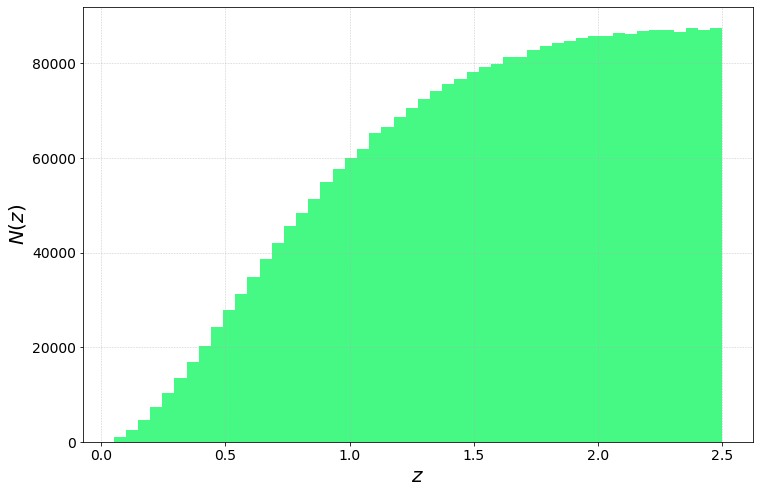

In [22]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

#nbins=30

(n_unif,bin_unif,patches_unif)=ax.hist(fastcat['z'],bins=nbins,range=(fastcat_zmin,fastcat_zmax),color=colors[9])

#ax.plot(mybins,myN(mybins),color=colors[3])
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=20)

In [23]:
#z_cut=0.8
#fast_cutted=fastcat[fastcat['z']>=z_cut]
fast_cutted=fastcat
fast_cutted_zmin=np.min(fast_cutted['z'])
fast_cutted_zmax=np.max(fast_cutted['z'])

nbins=30

Text(0, 0.5, '$N(z)$')

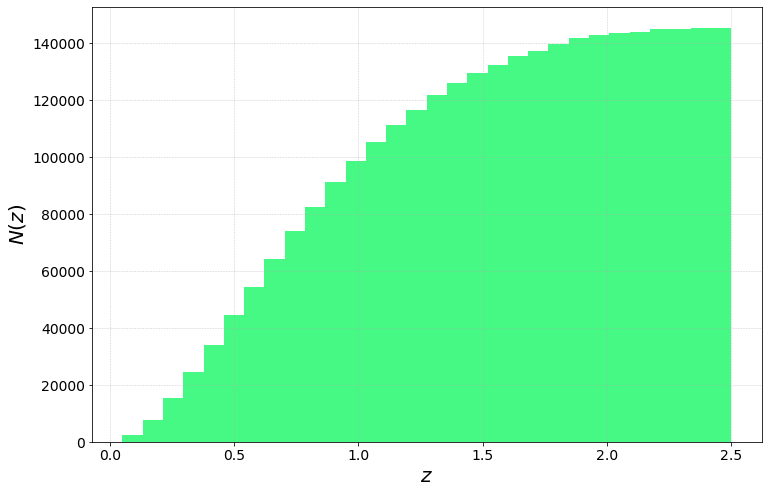

In [24]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

#nbins=30

(n_unif,bin_unif,patches_unif)=ax.hist(fast_cutted['z'],bins=nbins,range=(fast_cutted_zmin,fast_cutted_zmax),color=colors[9])

#ax.plot(mybins,myN(mybins),color=colors[3])
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=20)

In [25]:
print(fast_cutted.shape[0])

3000000


In [27]:
zpicco=1.1
alpha=2
gamma=1
beta=1.82#gamma*(alpha/zpicco)
check=(alpha*gamma)/beta
print(alpha,beta,gamma,check)

2 1.82 1 1.0989010989010988


In [28]:
#fake_nz=lambda x: 1/x**2
fake_nz=lambda x: (x**alpha)*np.exp(-((x**beta)/gamma))
deriv=lambda x: (x**(alpha-1))*np.exp(-((x**beta)/gamma))*(alpha-beta*x**(beta)/gamma)
N_extraction=1000_000
z_genrated=return_samples(fake_nz,fast_cutted_zmin,fast_cutted_zmax,N_extraction)

Text(0, 0.5, '$N(z)$')

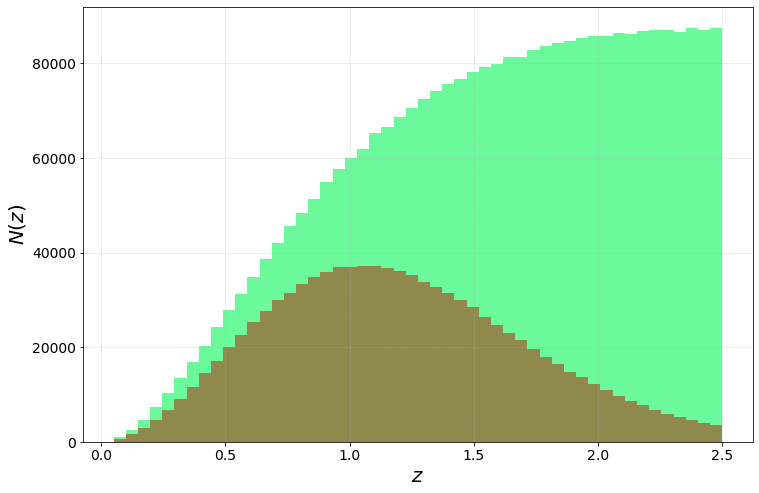

In [29]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

nbins=50

(n_unif,bin_unif,patches_unif)=ax.hist(fast_cutted['z'],bins=nbins,range=(fast_cutted_zmin,fast_cutted_zmax),
                                       color=colors[9],alpha=0.8)
(n_sel,bin_sel,patches_sel)=ax.hist(z_genrated,bins=nbins,range=(fast_cutted_zmin,fast_cutted_zmax),
                                    color=colors[1],alpha=0.5)

#ax.plot(mybins,myN(mybins),color=colors[3])
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=20)

In [30]:
mask=n_sel>n_unif
print(np.sum(mask))#if is 0 then ok

0


In [31]:
testdiluted = pd.DataFrame(columns = colnames)
half_step=(bin_unif[1]-bin_unif[0])/2
mybins=bin_unif[:-1]+half_step
for i in range(len(mybins)):
    temp_bin=fast_cutted[fast_cutted['z']>=mybins[i]-half_step]
    temp_bin=temp_bin[temp_bin['z']<=mybins[i]+half_step]
    temp_bin=temp_bin.sample(round(n_sel[i]))
    testdiluted=testdiluted.append(temp_bin, ignore_index=True)

In [ ]:
testdiluted.head()

Text(0, 0.5, '$N(z)$')

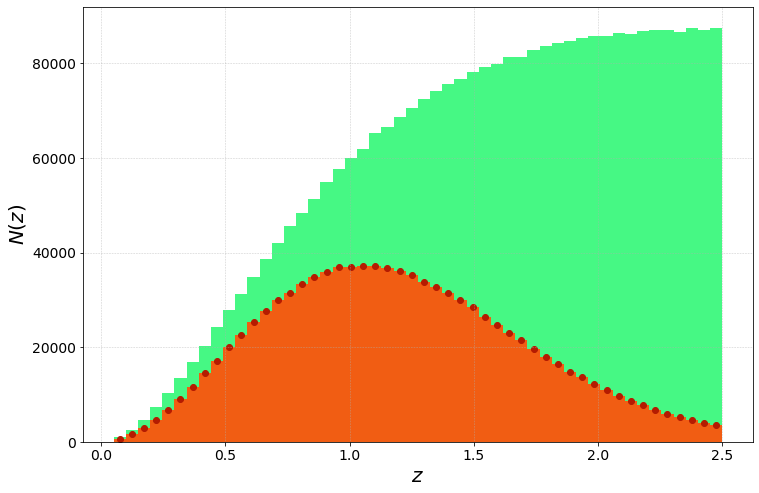

In [32]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

#nbins=30

(n_unif,bin_unif,patches_unif)=ax.hist(fast_cutted['z'],bins=nbins,range=(fast_cutted_zmin,fast_cutted_zmax),color=colors[9])
(n_sel,bin_sel,patches_sel)=ax.hist(testdiluted['z'],bins=nbins,range=(fast_cutted_zmin,fast_cutted_zmax),color=colors[3])

ax.scatter(mybins,n_sel,color=colors[1])
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=20)

In [33]:
testdiluted.shape[0]

1000000

In [ ]:
os.chdir(save_cat_path)
#testdiluted.to_csv('Nz01.txt', header=None, index=None, sep=' ')
#fast_cutted.to_csv('CuttedFast.txt', header=None, index=None, sep=' ')

In [ ]:
flag_over_unif=n_sel/n_unif
print(np.max(flag_over_unif))
normed_ratio=flag_over_unif/np.sum(flag_over_unif)
w_hist=1/flag_over_unif
w_normed=w_hist/np.sum(w_hist)
w=interpolate.interp1d(mybins,w_normed,kind='cubic',fill_value='extrapolate')
nn=interpolate.interp1d(mybins,normed_ratio,kind='cubic',fill_value='extrapolate')
#dd=interpolate.interp1d(mybins,dd,kind='cubic',fill_value='extrapolate')

In [ ]:
np.savetxt('Nz01_bin.txt', mybins)
np.savetxt('Nz01_weights.txt', w_normed)

In [ ]:
# Test reverse 

In [35]:
zpicco=1.1
alpha=2
gamma=0.5
beta=1#gamma*(alpha/zpicco)
check=(alpha*gamma)/beta
print(alpha,beta,gamma,check)

2 1 0.5 1.0


In [36]:
#fake_nz=lambda x: 1/x**2
fake_nz=lambda x: (x**alpha)*np.exp(-((x**beta)/gamma))
deriv=lambda x: (x**(alpha-1))*np.exp(-((x**beta)/gamma))*(alpha-beta*x**(beta)/gamma)
N_extraction=1000_000
z_genrated=return_samples(fake_nz,fast_cutted_zmin,fast_cutted_zmax,N_extraction)

In [37]:
(n_sel00,bin_sel,patches_sel)=ax.hist(z_genrated,bins=nbins,range=(fast_cutted_zmin,fast_cutted_zmax),
                                    color=colors[1],alpha=0.5)

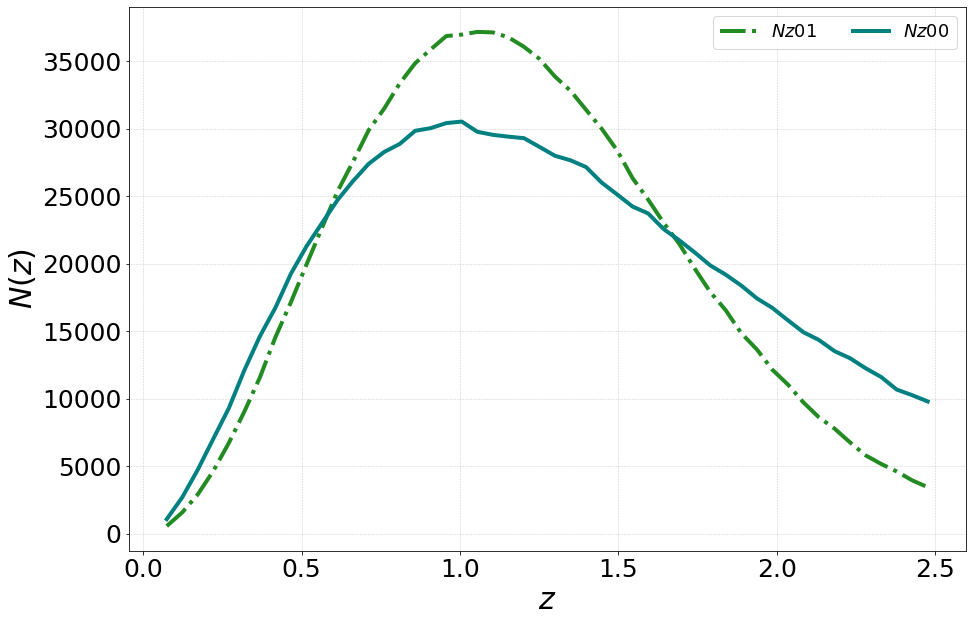

In [44]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
#xmin=np.min(x)
#xmax=np.max(x)
#href=67
#ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$z$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=30)
#if xmin<href<xmax:
#    ax.axvline(x = href, color = 'k', linestyle='dashdot')



#ax.plot(x,ds02/np.trapz(ds02,x),label=r'$DS-CUT02$',color='maroon',linewidth=4,linestyle=':')
#ax.plot(x,ds01/np.trapz(ds01,x),label=r'$DS-CUT01$',color='orange',linewidth=4,linestyle='--')

ax.plot(mybins,n_sel,label=r'$Nz01$',color='forestgreen',linewidth=4,linestyle='-.')

ax.plot(mybins,n_sel00,label=r'$Nz00$',color='teal',linewidth=4,linestyle='solid')
#ax.scatter(mybins,n_sel00,color=colors[1])
#ax.scatter(mybins,n_sel,color=colors[10])
#dist=(ref)/np.trapz(ref,x)
#mean=np.trapz(x*dist,x)/np.trapz(dist,x)
#std=np.sqrt(np.trapz(dist*(x-mean)**2,x)/np.trapz(dist,x))
#plt.figtext(0.75,0.60,'Mean={:0.2f}'.format(mean),fontsize=20,c='teal')
#plt.figtext(0.75,0.55,'Std={:0.2f}'.format(std),fontsize=20, c='teal')
#print('mean={},std={} std/mean={}%'.format(mean,std,100*std/mean))

#dist=(dl20_05_new)/np.trapz(dl20_05_new,x)
#mean=np.trapz(x*dist,x)/np.trapz(dist,x)
#std=np.sqrt(np.trapz(dist*(x-mean)**2,x)/np.trapz(dist,x))
#plt.figtext(0.75,0.45,'Mean={:0.2f}'.format(mean),fontsize=20,c='forestgreen')
#plt.figtext(0.75,0.40,'Std={:0.2f}'.format(std),fontsize=20, c='forestgreen')
#print('mean={},std={} std/mean={}%'.format(mean,std,100*std/mean))

ax.legend(fontsize=18, ncol=2)  
save_folder='/home/rciancarella/DarkSirensStat/MyDSStat/Figures'
#os.chdir(save_folder)
#plt.savefig('Nzplot.png') 
#os.chdir(folder)

In [ ]:
f=1/w_hist
print(len(mybins))

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

#nbins=30

(n_unif,bin_unif,patches_unif)=ax.hist(fast_cutted['z'],bins=nbins,range=(fast_cutted_zmin,fast_cutted_zmax),color=colors[9])

#ax.plot(mybins,myN(mybins),color=colors[3])
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=20)

In [ ]:
testpesi= pd.DataFrame(columns = colnames)

In [ ]:
for i in range(len(mybins)):
    temp_bin=fast_cutted[fast_cutted['z']>=mybins[i]-half_step]
    temp_bin=temp_bin[temp_bin['z']<=mybins[i]+half_step]
    temp_bin=temp_bin.sample(round(n_unif[i]*rapporto[i]))
    testpesi=testpesi.append(temp_bin, ignore_index=True)

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

nbins=30

(n_unif,bin_unif,patches_unif)=ax.hist(fast_cutted['z'],bins=nbins,range=(fast_cutted_zmin,fast_cutted_zmax),color=colors[9])
(n_test,bin_test,patches_test)=ax.hist(testpesi['z'],bins=nbins,range=(fast_cutted_zmin,fast_cutted_zmax),color=colors[3])

#ax.scatter(mybins,n_sel,color='purple')

#ax.set_xlabel(r'$z$', fontsize=20)
#ax.set_ylabel(r'$N(z)$', fontsize=20)

In [ ]:
passo=(bin_unif[1]-bin_unif[0])/2
f=interpolate.interp1d(bin_unif[:-1]+passo,n_test/n_unif,kind='linear',fill_value='extrapolate')

In [ ]:
N_zpesi=f(fast_cutted['z'])
#zfortest=np.linspace(0.05,2.5,N_extraction)

In [ ]:
print(N_zpesi[0:30])

In [ ]:
u_mc = np.random.uniform(0,1,size=len(fast_cutted['z']))
mask=N_zpesi>=u_mc

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

#nbins=30

(n_mask,bin_mask,patches_mask)=ax.hist(fast_cutted['z'],bins=nbins,range=(fast_cutted_zmin,fast_cutted_zmax),
                                       color=colors[9],weights=N_zpesi,density=True)
#(n_test,bin_test,patches_test)=ax.hist(z_genrated,bins=nbins,
#                                       range=(fast_cutted_zmin,fast_cutted_zmax),
#                                       color=colors[3])
ax.plot(zfortest,fake_nz(zfortest)/np.trapz(fake_nz(zfortest),zfortest),color='purple',lw=4)
#ax.scatter(allz,N_zpesi,color='purple')
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=20)

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

#nbins=30

(n_mask,bin_mask,patches_mask)=ax.hist(fast_cutted['z'][mask],bins=nbins,range=(fast_cutted_zmin,fast_cutted_zmax),
                                       color=colors[9],density=True,edgecolor = 'black',
                                       ls='--',lw=1.5,fc=(1, 1, 1, 1))
(n_check,bin_check,patches_check)=ax.hist(testpesi['z'],bins=nbins,
                                       range=(fast_cutted_zmin,fast_cutted_zmax),
                                       color=colors[3],density=True,alpha=0.8)
#ax.plot(zfortest,fake_nz(zfortest)/np.trapz(fake_nz(zfortest),zfortest),color='purple',lw=4)
#ax.scatter(allz,N_zpesi,color='purple')
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=20)

# Test Robustezza------ Sezione 1

In [5]:
os.chdir(save_cat_path)
fastcat = pd.read_csv('Uniform_for_half_flag.txt', sep=" ", header=None)
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
fastcat.columns=colnames
zinf=np.min(fastcat['z'])
zsup=np.max(fastcat['z'])

In [ ]:
zmin_cut=0.3
zmax_cut=1.6
fast_cutted=fastcat[fastcat['z']>=zmin_cut]
fast_cutted=fast_cutted[fast_cutted['z']<=zmax_cut]
fast_cutted_zmin=np.min(fast_cutted['z'])
fast_cutted_zmax=np.max(fast_cutted['z'])
nbins=70

Text(0, 0.5, '$N(z)$')

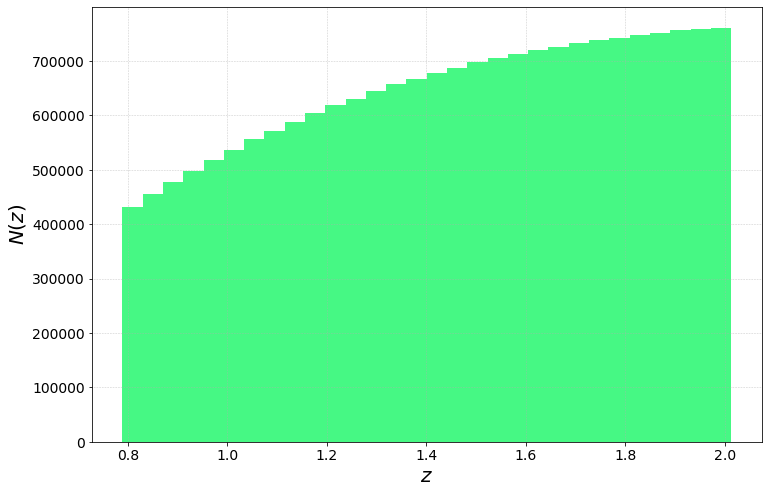

In [6]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

nbins=30
(n_mother,bin_mother,patches_mother)=ax.hist(fastcat['z'],bins=nbins,range=(zinf,zsup),color=colors[9])
#(n_cut,bin_cut,patches_cut)=ax.hist(fast_cutted['z'],bins=nbins,range=(zinf,zsup),color=colors[2])

#ax.plot(mybins,myN(mybins),color=colors[3])
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=20)

In [ ]:
os.chdir(save_cat_path)
fast_cutted.to_csv('HostFullCut02.txt', header=None, index=None, sep=' ')

# Scatteirng for all the hosts

In [11]:
os.chdir(save_cat_path)
fastcat = pd.read_csv('Uniform_for_half_flag.txt', sep=" ", header=None)
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
fastcat.columns=colnames
oldsca=fastcat['scattered DL']

In [6]:
fastcat.head()

,Ngal,Comoving Distance,Luminosity Distance,z,phi,theta,scattered DL
0,18272350,3624.440908,7563.746800,1.086873,1.090505,0.554396,7609.837990
1,10972031,5219.862175,15287.671535,1.928750,0.170652,0.528299,16247.512597
2,7030924,5018.219985,14050.580864,1.799913,0.153139,1.237979,14307.376284
3,26689126,4353.101173,10558.860979,1.425595,0.408890,1.315107,9835.548062
4,24844067,5303.452497,15828.478021,1.984561,1.263970,1.413369,16064.409482


In [7]:
dlsigma=0.20

In [8]:
ds_dl=np.asarray(fastcat['Luminosity Distance'])

sca= np.random.normal(loc=ds_dl, scale=ds_dl*dlsigma, size=None)#scattered[i]#
fastcat.drop(columns=['scattered DL'])
fastcat['scattered DL']=sca
fastcat.head()

,Ngal,Comoving Distance,Luminosity Distance,z,phi,theta,scattered DL
0,18272350,3624.440908,7563.746800,1.086873,1.090505,0.554396,5395.356343
1,10972031,5219.862175,15287.671535,1.928750,0.170652,0.528299,15222.854167
2,7030924,5018.219985,14050.580864,1.799913,0.153139,1.237979,14857.679790
3,26689126,4353.101173,10558.860979,1.425595,0.408890,1.315107,7767.370352
4,24844067,5303.452497,15828.478021,1.984561,1.263970,1.413369,15537.121895


In [9]:
#fastcat.to_csv('Uniform_for_half_flag-20scatt.txt', header=None, index=None, sep=' ')

0.6084272326677739 1132.8138649038867
0.00043508206372042216
0.682680545157205


Text(0.5, 0, '$(dl true-dl scatter) / Sigma$')

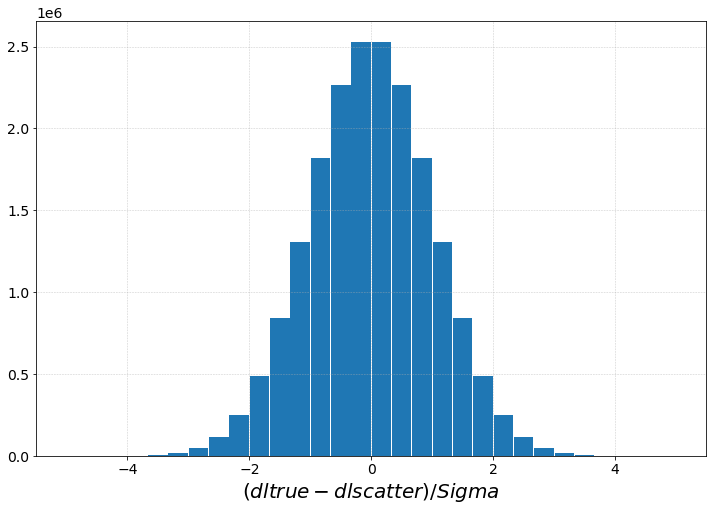

In [13]:
truedl=fastcat['Luminosity Distance']
scatdl=fastcat['scattered DL']
diff=(truedl-scatdl)#/(truedl)

mean=np.mean(diff)
std=np.std(diff)
allsigma=truedl*0.10
print(mean,std)
norm_diff=diff/allsigma
print(np.mean(norm_diff))
test=norm_diff[norm_diff>=-1]
test=test[test<=1]
print(len(test)/len(norm_diff))

norm_diff=norm_diff-np.mean(norm_diff)
#print(np.mean(norm_diff))
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))


nbins=30
(n_norm, bins_norm, patches)=ax.hist(norm_diff,bins=nbins,
                                     range=(-5,5),rwidth=0.96)

ax.set_xlabel(r'$(dl true-dl scatter) / Sigma$', fontsize=20)

In [14]:
mean=np.mean(norm_diff)
std=np.std(norm_diff)
median=np.median(norm_diff)
print(mean,std,median)
skw=3*(mean-median)/std
print(skw)

-1.1405853756020461e-17 1.0000903567909032 0.00020006172593352967
-0.0006001309518936885


In [20]:
mydlmax=10400
mydlmin=8950
NumDS=100000
phi_min=fastcat['phi'].min()
phi_max=fastcat['phi'].max()
theta_min=fastcat['theta'].min()
theta_max=fastcat['theta'].max()
radius_deg= np.sqrt(10/np.pi)
sigma90=radius_deg/np.sqrt(2)
sigma_deg=sigma90/1.5
circle_deg=6*sigma_deg
sigma_theta=np.radians(sigma_deg)
sigma_phi=np.radians(sigma_deg)

cutted=fastcat[fastcat['scattered DL']<=mydlmax]
cutted=cutted[cutted['scattered DL']>=mydlmin]
#---------------------------------------------
cutted=cutted[cutted['phi']<= phi_max-10*sigma_phi]
cutted=cutted[cutted['phi']>= phi_min+10*sigma_phi]
cutted=cutted[cutted['theta']<= theta_max-10*sigma_theta]
cutted=cutted[cutted['theta']>= theta_min+10*sigma_theta]
print('possible DSs: {}'.format(cutted.shape[0]))
print('N_DS/N_poss = {}'.format(NumDS/cutted.shape[0]))

possible DSs: 1794852
N_DS/N_poss = 0.055714900170041874


# N(DL)

In [45]:
href=67
dlmax=11_000
dlmin=6800
from numpy.random import random
#-----------rejection-stuff------------
def sample(g,xmin,xmax):
    x = np.linspace(xmin,xmax,1000000)
    y = g(x)                        # probability density function, pdf
    cdf_y = np.cumsum(y)            # cumulative distribution function, cdf
    cdf_y = cdf_y/cdf_y.max()       # -takes care of normalizing cdf to 1.0
    inverse_cdf = interpolate.interp1d(cdf_y,x,fill_value="extrapolate")# this is a function
    #inverse_cdf = np.interp(0,cdf_y,x) #this works but it is not a function
    return inverse_cdf
def return_samples(f,xmin,xmax,N=1000000):
    # let's generate some samples according to the chosen pdf, f(x)
    uniform_samples = random(int(N))       
    required_samples = sample(f,xmin,xmax)(uniform_samples)
    return required_samples

In [46]:
os.chdir(save_cat_path)
fastcat = pd.read_csv('half_flag.txt', sep=" ", header=None)
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
fastcat.columns=colnames

In [47]:
path='/home/rciancarella/DarkSirensStat/MyDSStat/results'
source_folder='CatDS'
data_path=os.path.join(path,source_folder)
DSsample=fastcat[fastcat['scattered DL']<=dlmax]
DSsample=DSsample[DSsample['scattered DL']>=dlmin]

DSsample.shape[0]

3281639

In [ ]:
save_DS_path='/home/rciancarella/DarkSirensStat/MyDSStat/results/DScat-extracted/'
os.chdir(data_path)
DSsample.to_csv('DScat_half_flag.txt',header=None, index=None, sep=' ')

10999.99839797889


Text(0, 0.5, '$N(dl)$')

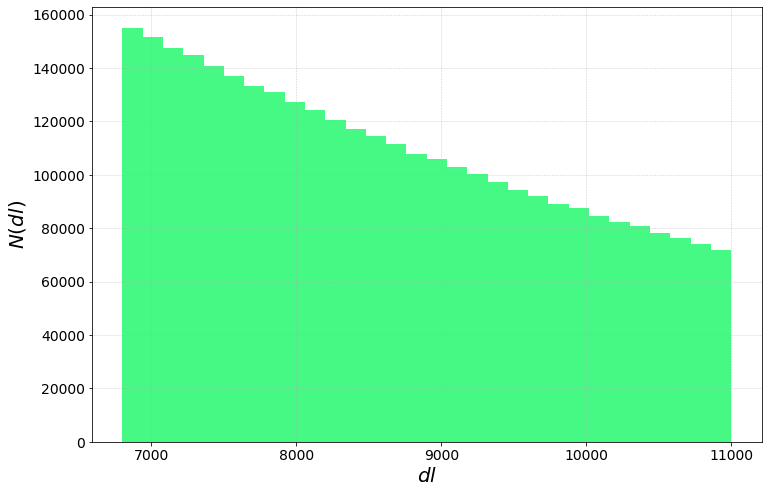

In [48]:
nbins=30
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))


scatter_dlmin=DSsample['scattered DL'].min()
scatter_dlmax=DSsample['scattered DL'].max()
print(scatter_dlmax)
(n_start,bin_start,patches_start)=ax.hist(DSsample['scattered DL'],bins=nbins,
                                          range=(dlmin,dlmax),color=colors[9])
ax.set_xlabel(r'$dl$', fontsize=20)
ax.set_ylabel(r'$N(dl)$', fontsize=20)


In [50]:
scatter_dlmed=(dlmax-dlmin)/2 +dlmin#scatter_dlmin+(scatter_dlmax-scatter_dlmin)/2
sigma=scatter_dlmed*0.22
alpha=2
beta=2
#print(alpha,beta,xp,alpha*xp**beta)
x=np.linspace(dlmin,dlmax,1000)
roof=1/(dlmax-dlmin)
UnifPdet=lambda x: x*0+1/(dlmax-dlmin)
#mydist= lambda x: np.heaviside(dlmed-x,1)*0.5/(dlmax-dlmin)+np.heaviside(x-dlmed,1)*0.25/(dlmax-dlmin)
mydist_DS= lambda x: ((x/scatter_dlmed)**alpha)*np.exp(-((x/scatter_dlmed)**(beta)))
Gauss_DS=lambda x:np.exp(-((x-scatter_dlmed)**(2))/(2*sigma**2))

In [51]:
#tmp=DSsample[DSsample['Luminosity Distance']>=dlmin]
#tmp=tmp[tmp['Luminosity Distance']<=dlmed]
#first=tmp.sample(frac=0.5)
dls=np.linspace(scatter_dlmin,scatter_dlmax,10000)
nsamp=DSsample.shape[0]/2
dl_generated=return_samples(mydist_DS,dlmin,dlmax,nsamp)

Text(0, 0.5, '$N(dl)$')

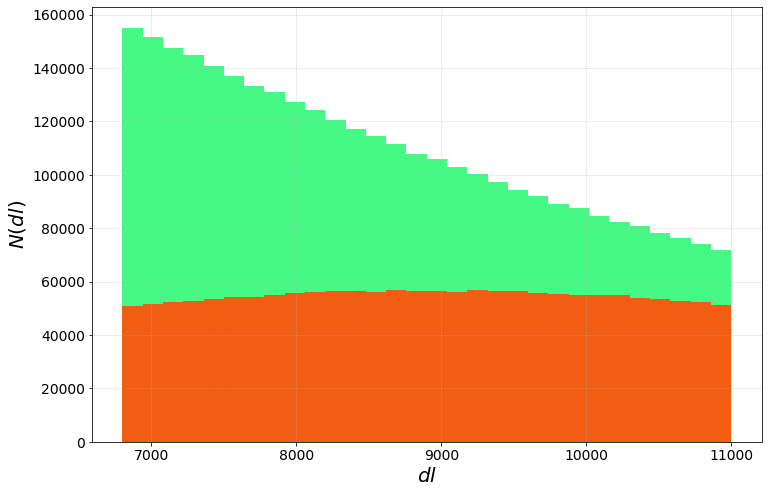

In [52]:
nbins=30
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

(n_start,bin_start,patches_start)=ax.hist(DSsample['scattered DL'],bins=nbins,
                                          range=(scatter_dlmin,scatter_dlmax),color=colors[9])
(n_first,bin_first,patches_first)=ax.hist(dl_generated,bins=nbins,
                                          range=(scatter_dlmin,scatter_dlmax),color=colors[3])

#ax.plot(dls,mydist_DS(dls)*7000,color='purple')
ax.set_xlabel(r'$dl$', fontsize=20)
ax.set_ylabel(r'$N(dl)$', fontsize=20)

In [53]:
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
DSextracted = pd.DataFrame(columns = colnames)
half_step=(bin_start[1]-bin_start[0])/2
mybins=bin_start[:-1]+half_step
for i in range(len(mybins)):
    temp_bin=DSsample[DSsample['scattered DL']>=mybins[i]-half_step]
    temp_bin=temp_bin[temp_bin['scattered DL']<=mybins[i]+half_step]
    temp_bin=temp_bin.sample(round(n_first[i]))
    DSextracted=DSextracted.append(temp_bin, ignore_index=True)

In [54]:
print(half_step)

69.9999707335046


Text(0, 0.5, '$N(dl)$')

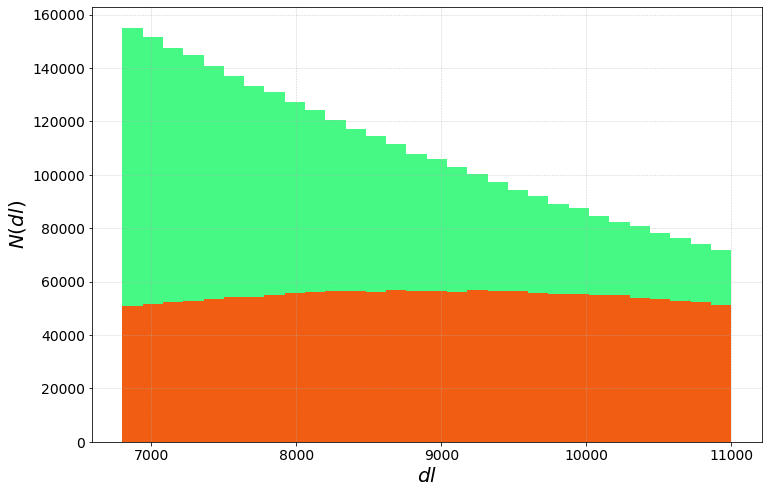

In [55]:
nbins=30
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

(n_start,bin_start,patches_start)=ax.hist(DSsample['scattered DL'],bins=nbins,
                                          range=(dlmin,dlmax),color=colors[9])
(n_extracted,bin_extracted,patches_extracted)=ax.hist(DSextracted['scattered DL'],bins=nbins,
                                          range=(dlmin,dlmax),color=colors[3])


ax.set_xlabel(r'$dl$', fontsize=20)
ax.set_ylabel(r'$N(dl)$', fontsize=20)

In [ ]:
save_DS_path='/home/rciancarella/DarkSirensStat/MyDSStat/results/DScat-extracted/'
os.chdir(save_DS_path)
tosave=DSextracted.sample(150)
tosave.to_csv('DScat-extracted_DSs.txt',header=None, index=None, sep=' ')

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

ax.set_xlim(dlmin, dlmax)
ax.set_ylim(0, roof*1.1)
ax.set_xlabel(r'$Dl(Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$P(Dl)$', fontsize=30)

ax.plot(x,UnifPdet(x),label='Pdet',color='Teal',linewidth=3,linestyle='solid')
ax.plot(x,mydist(x),label='$\eta$',color='Purple',linewidth=3,linestyle='dashdot')
#ax.plot(x,mygaussdist(x)/np.trapz(mygaussdist(x),x),label='$\eta$',color='Seagreen',linewidth=3,linestyle='dotted')


In [ ]:
halfstep=x[1]-x[0]
bincenter=x+halfstep
sel_over_true=mydist(bincenter)/UnifPdet(bincenter)
pesi=1/sel_over_true
pesi=pesi/np.max(pesi)

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

ax.set_xlim(dlmin, dlmax)
ax.set_xlabel(r'$Dl(Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$\eta (Dl)$', fontsize=30)

ax.plot(bincenter,pesi,label='Pesi',color='Seagreen',linewidth=3,linestyle='solid')


In [ ]:
np.savetxt('gamma00_bin.txt', bincenter)
np.savetxt('gamma00_weights.txt', pesi)

In [ ]:
os.chdir(save_cat_path)
cat_name='FullExplorer_big.txt'
MyCat = pd.read_csv(cat_name, sep=" ", header=None)
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
MyCat.columns=colnames

In [ ]:
dl_min=MyCat['scattered DL'].min()
dl_max=MyCat['scattered DL'].max()
print(dl_min,dl_max)

# How Many Host

In [4]:
os.chdir(save_cat_path)
MyCat = pd.read_csv('half_flag.txt', sep=" ", header=None)
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
MyCat.columns=colnames

In [11]:
    #---------angular stuff------------------
    radius_deg= np.sqrt(10/np.pi)
    sigma90=radius_deg/np.sqrt(2)
    sigma_deg=sigma90/1.5
    circle_deg=6*sigma_deg
    sigma_theta=np.radians(sigma_deg)
    sigma_phi=np.radians(sigma_deg)
    radius_rad=np.radians(circle_deg)
    conc=1/(sigma_phi**2)
    phi_min=MyCat['phi'].min()
    phi_max=MyCat['phi'].max()
    theta_min=MyCat['theta'].min()
    theta_max=MyCat['theta'].max()

In [6]:
    NumDS=150#150 
    mydlmax=10_700#Dl_z(zds_max,href,Om0GLOB)
    mydlmin=8_350#Dl_z(zds_min,href,Om0GLOB)

    #-----------------------------------------------------------------------------
    #cutted=MyCat[MyCat['Comoving Distance']<=mydcmax]
    #cutted=cutted[cutted['Comoving Distance']>=mydcmin]
    #----------selection on scarred Dl
    cutted=MyCat[MyCat['scattered DL']<=mydlmax]
    cutted=cutted[cutted['scattered DL']>=mydlmin]
    #---------------------------------------------
    cutted=cutted[cutted['phi']<= phi_max-10*sigma_phi]
    cutted=cutted[cutted['phi']>= phi_min+10*sigma_phi]
    cutted=cutted[cutted['theta']<= theta_max-10*sigma_theta]
    cutted=cutted[cutted['theta']>= theta_min+10*sigma_theta]
    sample=cutted.sample(NumDS) #This is the DS cat

    ds_z=np.asarray(sample['z'])
    ds_dl=np.asarray(sample['Luminosity Distance'])
    ds_phi=np.asarray(sample['phi'])
    ds_theta=np.asarray(sample['theta'])
    sca= np.asarray(sample['scattered DL'])

In [12]:
dlsigma=0.1
s=dlsigma
how_many_sigma=3.5
ang_sigma=3.5
Nhosts=[]

In [13]:
for i in tqdm(range(NumDS)):
    DS_phi=ds_phi[i]
    #tmp=MyCat
    #print(sigma_phi,DS_phi)
    tmp=MyCat[MyCat['phi']<=DS_phi+ang_sigma*sigma_phi]
    tmp=tmp[tmp['phi']>=DS_phi-ang_sigma*sigma_phi]
    DS_theta=ds_theta[i]
    #print(sigma_phi,DS_theta)
    tmp=tmp[tmp['theta']<=DS_theta+ang_sigma*sigma_phi]
    tmp=tmp[tmp['theta']>=DS_theta-ang_sigma*sigma_phi]
    true_mu=ds_dl[i]
    mu=sca[i]
    zz=ds_z[i]
    dlrange=s*mu*how_many_sigma
    tmp=tmp[tmp['Luminosity Distance']<=mu+dlrange]
    tmp=tmp[tmp['Luminosity Distance']>=mu-dlrange]
    Nhosts.append(len(tmp))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:25<00:00,  5.83it/s]


In [14]:
N10deg=Nhosts
N10deg=np.asarray(N10deg)
np.mean(N10deg)

24798.04

In [10]:
N20deg=Nhosts
N20deg=np.asarray(N20deg)
np.mean(N20deg)

49598.386666666665

In [15]:
print(N20deg-N10deg)

[32807 29866 28676 21900 25666 25781 29746 28833 32449 31468 14581 24477
 20268 33450 16946 14763 30060 29685 31020 19239 30767 16874 32215 27668
  7862 19396 21161 28867 32384 26821 26717 14537 17478 21599 13746 15770
 26308 27927 30383 25768 17394 31533 23244 23199 16335 10534 27669 23762
 28488 24288 17076 32452 29705 31729 26429 26574 24858 29337 29901 32974
 23877 28916 24335 26413 28688 23753 23927 15098 23651 29786 19534 24215
 29952 22701 11550 27489 23916 27130 32352 29226 21433 27239 20449 14809
 10979 29266 11011  8938 29375 30656 27356 25610 20464 30262 29001 27988
 26755  6675 33737 24179 23638 30875 15808 24583 27228  9945 22633 29820
 21819 15666 10022 31275 28717 31676 32103 27761 20369 32344 14702 29306
 31983 32746 30538 25928 33442 27574 29020 23545 19189 25406 16624 29623
 30467 21510 30289 28059 20902 29868 32630 18587 30657 27275 29936 28342
 27887 10685 17753 19998 32866 30332]


In [16]:
print(np.mean(N20deg-N10deg))
#print(np.mean(N20deg)-np.mean(N10deg))

24800.346666666668


Text(0, 0.5, '$N-hosts$')

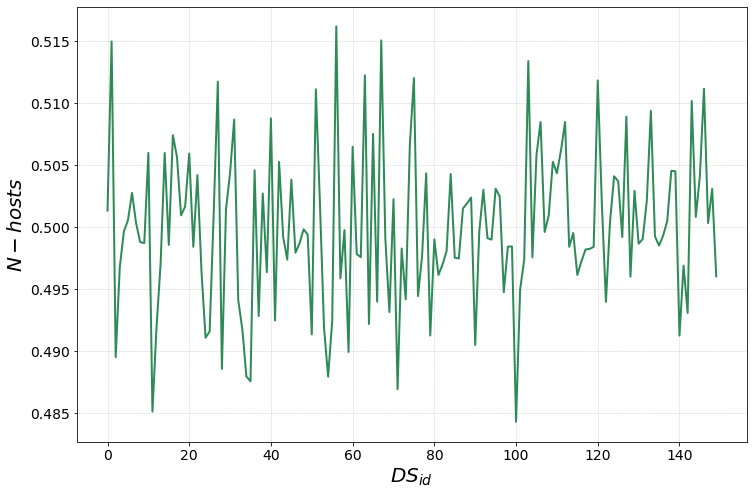

In [20]:
x=np.arange(0,NumDS)
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

#ax.axhline(y = np.mean(N10deg), color = 'purple', linestyle='dashdot')
#ax.axhline(y = np.mean(N20deg), color = 'teal', linestyle='dashdot')

#ax.scatter(x,N20deg,label='first',color='teal',linewidth=2,linestyle='solid')
#ax.scatter(x,N10deg,label='first',color='purple',linewidth=2,linestyle='solid')
#ax.plot(x,(N20deg-N10deg),label='first',color='seagreen',linewidth=2,linestyle='solid')
ax.plot(x,(N10deg/N20deg),label='first',color='seagreen',linewidth=2,linestyle='solid')

ax.set_xlabel(r'$DS_{id}$', fontsize=20)
ax.set_ylabel(r'$N-hosts$', fontsize=20)

# Scattering

In [5]:
os.chdir(save_cat_path)
MyCat = pd.read_csv('Uniform_for_half_flag.txt', sep=" ", header=None)
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
MyCat.columns=colnames

In [ ]:
dl_true=MyCat['Luminosity Distance']

In [ ]:
dlsigma=0.15
sca= np.random.normal(loc=dl_true, scale=dl_true*dlsigma, size=None)

# Pesi per Tesi

In [15]:
os.chdir(save_cat_path)
MyCat = pd.read_csv('half_flag.txt', sep=" ", header=None)
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
MyCat.columns=colnames

os.chdir(save_cat_path)
Ucat = pd.read_csv('TrueFlag_half.txt', sep=" ", header=None)
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']#,'scattered DL']
Ucat.columns=colnames

In [14]:
MyCat.shape[0]

7023766

In [16]:
MyCat.head()

,Ngal,Comoving Distance,Luminosity Distance,z,phi,theta,scattered DL
0,162553,3584.400024,7419.794123,1.070024,0.381199,0.846124,6076.867833
1,13738306,4261.288416,10138.625972,1.379240,0.237092,1.464663,11034.018731
2,11855738,4258.338280,10125.346249,1.377769,0.639525,1.390277,8740.551371
3,11322702,2940.702946,5352.028160,0.819983,0.946490,0.768274,5228.176759
4,11312620,3749.679527,8026.800329,1.140663,0.523851,0.141984,7147.400821


In [17]:
Ucat.head()

,Ngal,Comoving Distance,Luminosity Distance,z,phi,theta
0,3735337,5145.272135,14819.203792,1.880159,0.277323,0.726392
1,13528696,5272.613210,15626.972672,1.963800,1.142391,1.179168
2,8658382,3777.927670,8133.990403,1.153030,1.009314,0.279702
3,11494385,2946.213013,5367.913262,0.821971,1.506296,1.396265
4,11912049,4897.373690,13352.183370,1.726397,0.832865,1.182879


In [19]:
for z in MyCat['z']:
    if z == Ucat['z'][0]:
        print('Chirp!')

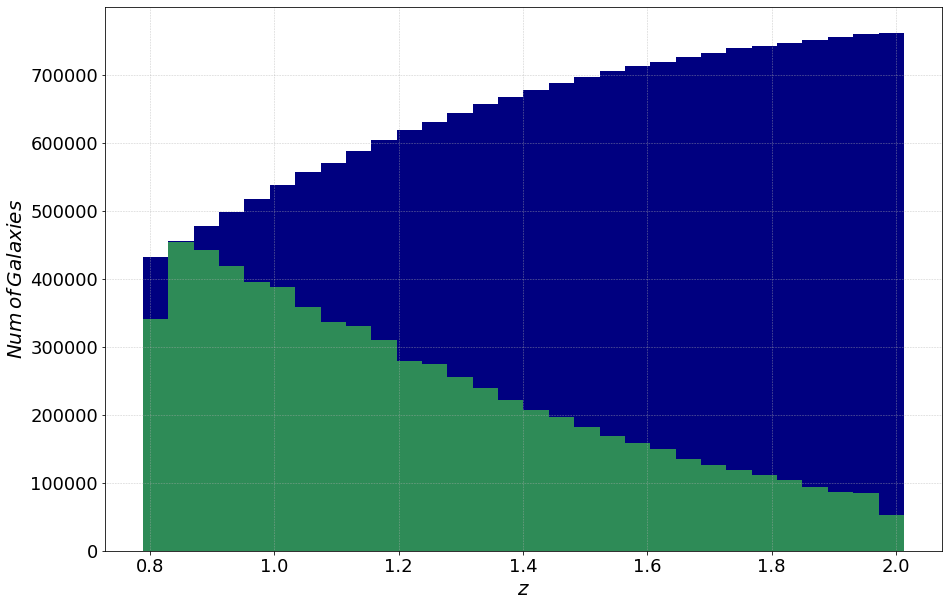

In [55]:
zmin=Ucat['z'].min()
zmax=Ucat['z'].max()
nbins=30
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=18)
ax.yaxis.get_offset_text().set_fontsize(18)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

(n_u,bin_u,patches_u)=ax.hist(Ucat['z'],bins=nbins,
                                          range=(zmin,zmax),color='navy')
(n_flag,bin_flag,patches_flag)=ax.hist(MyCat['z'],bins=nbins,
                                          range=(zmin,zmax),color='seagreen')


ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$Num\, of\, Galaxies$', fontsize=20)
plt.savefig('UvsN.png')